# Evalute result with non-paperaware
- We will evauluate pretrained weight `MobileNetV3-Large-2021-05-26-01-37-33-epoch0071-train_loss1.831597-val_loss1.799177-val_acc0.589499.zip` with previous (non-paperaware) model.
- Evauluation date: 2021/06/03


In [1]:
EVAL_WEIGHT_PATH = '/media/jungin500/windows-10/Workspace/study-projects/ipcvl2021-mobilenetv3-torch-v2/prepare/.checkpoints' + \
    '/MobileNetV3-Large-2021-05-26-01-37-33-epoch0071-train_loss1.831597-val_loss1.799177-val_acc0.589499.zip'
    
import os
if not os.path.isfile(EVAL_WEIGHT_PATH):
    print("Weight file not found! specify correct directory.")

In [2]:
import datetime

from torch.utils.data import Dataset
from torch import from_numpy
from PIL import Image
import glob

import os
import pickle
from xml.etree import ElementTree

import numpy as np
import torchsummary
import torch
from torch import nn
from torchvision import transforms
from tqdm import tqdm

In [3]:
'''
    ImageNet Label Reader (only for ImageNet datsets!)
'''
class LabelReader(object):
    def __init__(self, label_file_path):
        self.label_file_path = label_file_path
        if 'pretrained' in label_file_path:
            print("INFO: Using Pretrained label list! (not custom one)")

    def load_label(self):
        label_map = {}
        # Read label file into label map
        if os.path.isfile(self.label_file_path):
            with open(self.label_file_path, 'r') as f:
                label_name_body = f.read().strip()
                label_name_lines = label_name_body.split("\n")
                for label_entry in tqdm(label_name_lines, desc='레이블 파일 읽기 작업'):
                    synset_name, label_name = label_entry.strip().split("|")
                    label_map[synset_name] = label_name

            print(f"레이블 파일 읽기 완료: 총 {len(list(label_map.keys()))}개 레이블 검색")
            return label_map
        else:
            return None

In [4]:
CACHE_BASE_DIR = "." + os.sep + ".cache"
IMG_PATH_LIST_PKL_FILENAME = CACHE_BASE_DIR + os.sep + 'img_path_list'
IMG_CLASS_LIST_PKL_FILENAME = CACHE_BASE_DIR + os.sep + 'img_class_list'

'''
    ImageNet Dataset (we can get labels from `LabelReader(path).load_label()`!
'''
class ImageNet(torch.utils.data.Dataset):
    def __init__(self, labels, root_dir, transform=None):
        super(ImageNet, self).__init__()

        self.labels = labels
        self.transform = transform

        self.img_path_list = []
        self.img_class_list = []
        self.load_list(root_dir)

    def load_list(self, root_dir):
        label_index = 0
        for label in tqdm(self.labels.keys(), desc='이미지 파일 리스트 읽기 작업'):
            item_dir = os.path.join(root_dir, label)
            file_list = glob.glob(item_dir + os.sep + "*.JPEG")
            self.img_path_list += file_list
            self.img_class_list += [label_index] * len(file_list)
            label_index += 1

        if len(self.img_path_list) != len(self.img_class_list):
            raise RuntimeError(f"이미지 데이터 {len(self.img_path_list)}개와 클래스 데이터 {len(self.img_class_list)}개가 서로 다릅니다!")

        print(f"총 {len(self.img_path_list)}개 이미지 리스트 데이터 및 실효 레이블 {len(list(set(self.img_class_list)))}개 로드 성공")

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # PIL-version
        image = Image.open(self.img_path_list[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = torch.Tensor([self.img_class_list[idx]]).type(torch.int64).squeeze(dim=0)
        return image, label


In [5]:
'''
    VOC Dataset (without label! root_dir automatically scans for label list)
'''
class VOC(Dataset):
    def __init__(self, root_dir, transform=None):
        super(VOC, self).__init__()
        self.transform = transform

        self.img_path_list = []
        self.img_class_list = []
        self.labels = []

        if os.path.isfile('dataset.pkl'):
            print("Loading annotations from cache")
            self.img_path_list, self.img_class_list, self.labels = pickle.load(open('dataset.pkl', 'rb'))
        else:
            self.load_list(root_dir)
            print("Saved annotations to  cache")

        self.img_class_list = from_numpy(self.img_class_list)

    def load_list(self, root_dir):
        annotation_dir = os.path.join(root_dir, 'Annotations')
        images_dir = os.path.join(root_dir, 'JPEGImages')

        label_map = {}
        for xml_filename in tqdm(glob.glob(os.path.join(annotation_dir, '*.xml')), desc='클래스 리스트 생성 작업'):
            with open(xml_filename, 'r') as f:
                xml_body = f.read()
                root = ElementTree.fromstring(xml_body)
                for item in root.findall('object'):
                    label_map[item.find('name').text] = True
        self.labels = list(sorted(label_map.keys()))

        for xml_filename in tqdm(glob.glob(os.path.join(annotation_dir, '*.xml')), desc='이미지 어노테이션 읽기 작업'):
            with open(xml_filename, 'r') as f:
                xml_body = f.read()
                root = ElementTree.fromstring(xml_body)
                image_file_path = os.path.join(images_dir, root.find('filename').text)
                for item in root.findall('object'):
                    label_index = self.labels.index(item.find('name').text)
                    assert label_index != -1

                    self.img_path_list.append(image_file_path)
                    self.img_class_list.append(label_index)

        self.img_class_list = np.array(self.img_class_list, dtype=np.int64)
        pickle.dump((self.img_path_list, self.img_class_list, self.labels), open('dataset.pkl', 'wb'))

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        image = Image.open(self.img_path_list[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        label = self.img_class_list[idx]
        return image, label

In [6]:
'''
    MobileNetV3-Large Model Structure consisted of:
    - SqueezeExcite Module
    - Bottleneck Module
'''
class SqueezeExciteModule(nn.Module):
    def __init__(self, expand_size):
        super(SqueezeExciteModule, self).__init__()

        self.se_0_0 = nn.AdaptiveAvgPool2d(output_size=1)
        self.se_0_1 = nn.Flatten()

        self.se_1_0 = nn.Linear(in_features=expand_size, out_features=expand_size)
        self.se_1_1 = nn.ReLU(inplace=True)

        self.se_2_0 = nn.Linear(in_features=expand_size, out_features=expand_size)
        self.se_2_1 = nn.Hardsigmoid(inplace=True)

    def forward(self, x):
        x = self.se_0_0(x)
        x = self.se_0_1(x)

        x = self.se_1_0(x)
        x = self.se_1_1(x)

        x = self.se_2_0(x)
        x = self.se_2_1(x)
        x = torch.unsqueeze(x, -1)
        x = torch.unsqueeze(x, -1)
        return x


class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, dw_kernel_size, expand_size, squeeze_excite,
                 nonlinearity, stride):
        super(Bottleneck, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.expand_size = expand_size
        self.squeeze_excite = squeeze_excite
        self.stride = stride
        self.dw_kernel_size = dw_kernel_size

        if nonlinearity == 'hardswish':
            self.Nonliearity = nn.Hardswish
        elif nonlinearity == 'relu':
            self.Nonliearity = nn.ReLU
        else:
            raise RuntimeError("No such nonlinearity!")

        # 1x1 Conv2d + NL
        self.bottleneck_0_0 = nn.Conv2d(in_channels=in_channels, out_channels=expand_size, kernel_size=(1, 1),
                                        bias=False)
        self.bottleneck_0_1 = nn.BatchNorm2d(num_features=expand_size)
        self.bottleneck_0_2 = self.Nonliearity(inplace=True)

        # Dwise + NL
        self.bottleneck_1_0 = nn.Conv2d(in_channels=expand_size, out_channels=expand_size,
                                        kernel_size=self.dw_kernel_size,
                                        stride=self.stride, padding=self.dw_kernel_size[0] // 2, groups=expand_size,
                                        bias=False)
        self.bottleneck_1_1 = nn.BatchNorm2d(num_features=expand_size)

        # Squeeze-Excite
        if self.squeeze_excite:
            self.squeeze_excite_0 = SqueezeExciteModule(
                expand_size=expand_size
            )
        else:
            self.squeeze_excite_0 = nn.Identity()

        # Final 1x1 Conv2d
        self.bottleneck_final_0 = nn.Conv2d(in_channels=expand_size, out_channels=out_channels, kernel_size=(1, 1),
                                            bias=False)
        self.bottleneck_final_1 = nn.BatchNorm2d(num_features=out_channels)

        # Downsampling first layer
        self.bottleneck_final_2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                            kernel_size=(1, 1), stride=self.stride, bias=False)

    def forward(self, x):
        x_0 = self.bottleneck_0_0(x)
        x_0 = self.bottleneck_0_1(x_0)
        x_0 = self.bottleneck_0_2(x_0)

        x_0 = self.bottleneck_1_0(x_0)
        x_0 = self.bottleneck_1_1(x_0)

        x_1 = self.squeeze_excite_0(x_0)
        x_0 = x_0 * x_1

        x_0 = self.bottleneck_final_0(x_0)
        x_0 = self.bottleneck_final_1(x_0)
        x_b = self.bottleneck_final_2(x)
        return x_0.add(x_b)


class MobileNetV3(nn.Module):
    def __init__(self, width_mult=1.0, classifier=True, classifier_out_features=1000):
        super(MobileNetV3, self).__init__()

        conv_0_0 = nn.Conv2d(in_channels=3, out_channels=int(16 * width_mult),
                             kernel_size=(3, 3), stride=2, padding=3 // 2, bias=False)
        conv_0_1 = nn.BatchNorm2d(num_features=int(16 * width_mult))
        conv_0_2 = nn.Hardswish(inplace=True)

        conv_1_0 = Bottleneck(in_channels=int(16 * width_mult),
                              out_channels=int(16 * width_mult), dw_kernel_size=(3, 3),
                              expand_size=16, squeeze_excite=True, nonlinearity='relu', stride=2)
        conv_2_0 = Bottleneck(in_channels=int(16 * width_mult),
                              out_channels=int(24 * width_mult), dw_kernel_size=(3, 3),
                              expand_size=72, squeeze_excite=False, nonlinearity='relu', stride=2)
        conv_3_0 = Bottleneck(in_channels=int(24 * width_mult),
                              out_channels=int(24 * width_mult), dw_kernel_size=(3, 3),
                              expand_size=88, squeeze_excite=False, nonlinearity='relu', stride=1)
        conv_4_0 = Bottleneck(in_channels=int(24 * width_mult),
                              out_channels=int(40 * width_mult), dw_kernel_size=(5, 5),
                              expand_size=96, squeeze_excite=True, nonlinearity='hardswish', stride=2)
        conv_5_0 = Bottleneck(in_channels=int(40 * width_mult),
                              out_channels=int(40 * width_mult), dw_kernel_size=(5, 5),
                              expand_size=240, squeeze_excite=True, nonlinearity='hardswish', stride=1)
        conv_6_0 = Bottleneck(in_channels=int(40 * width_mult),
                              out_channels=int(40 * width_mult), dw_kernel_size=(5, 5),
                              expand_size=240, squeeze_excite=True, nonlinearity='hardswish', stride=1)
        conv_7_0 = Bottleneck(in_channels=int(40 * width_mult),
                              out_channels=int(48 * width_mult), dw_kernel_size=(5, 5),
                              expand_size=120, squeeze_excite=True, nonlinearity='hardswish', stride=1)
        conv_8_0 = Bottleneck(in_channels=int(48 * width_mult),
                              out_channels=int(48 * width_mult), dw_kernel_size=(5, 5),
                              expand_size=144, squeeze_excite=True, nonlinearity='hardswish', stride=1)
        conv_9_0 = Bottleneck(in_channels=int(48 * width_mult),
                              out_channels=int(96 * width_mult), dw_kernel_size=(5, 5),
                              expand_size=288, squeeze_excite=True, nonlinearity='hardswish', stride=2)
        conv_10_0 = Bottleneck(in_channels=int(96 * width_mult),
                               out_channels=int(96 * width_mult), dw_kernel_size=(5, 5),
                               expand_size=576, squeeze_excite=True, nonlinearity='hardswish', stride=1)
        conv_11_0 = Bottleneck(in_channels=int(96 * width_mult),
                               out_channels=int(96 * width_mult), dw_kernel_size=(5, 5),
                               expand_size=576, squeeze_excite=True, nonlinearity='hardswish', stride=1)

        conv_12_0 = nn.Conv2d(in_channels=int(96 * width_mult), out_channels=int(576 * width_mult),
                              kernel_size=(1, 1), bias=False)
        conv_12_1 = nn.Hardswish(inplace=True)
        conv_12_2 = nn.BatchNorm2d(num_features=int(576 * width_mult))

        self.features = nn.Sequential(
            conv_0_0,
            conv_0_1,
            conv_0_2,
            conv_1_0,
            conv_2_0,
            conv_3_0,
            conv_4_0,
            conv_5_0,
            conv_6_0,
            conv_7_0,
            conv_8_0,
            conv_9_0,
            conv_10_0,
            conv_11_0,
            conv_12_0,
            conv_12_1,
            conv_12_2
        )

        if classifier:
            self.classifiers = nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1),
                nn.Linear(int(576 * width_mult), int(1024 * width_mult)),
                nn.Dropout(p=0.2),
                nn.Linear(int(1024 * width_mult), classifier_out_features)
            )
        else:
            self.classifiers = nn.Identity()

    def forward(self, x):
        x = self.features(x)
        x = self.classifiers(x)
        return x

In [7]:
'''
    Library Configuration
'''
# CUDA-related stuffs
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda')

model = MobileNetV3(width_mult=1.0, classifier=True, classifier_out_features=1000).float().to(device)
torchsummary.summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             256
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7           [-1, 16, 56, 56]             144
       BatchNorm2d-8           [-1, 16, 56, 56]              32
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
          Flatten-10                   [-1, 16]               0
           Linear-11                   [-1, 16]             272
             ReLU-12                   [-1, 16]               0
           Linear-13                   [-1, 16]             272
      Hardsigmoid-14                   

In [42]:
labels = LabelReader(label_file_path='imagenet_label.custom.list').load_label()
datasets = ImageNet(
    labels=labels,
    root_dir='/media/jungin500/windows-10/Dataset/ILSVRC/Data/CLS-LOC/val-sub',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ])
)

valid_dataloader = torch.utils.data.DataLoader(datasets, batch_size=128, 
                                              shuffle=False, num_workers=16, pin_memory=True, drop_last=False)

checkpoint = torch.load(EVAL_WEIGHT_PATH)
c_epoch = checkpoint['epoch'] + 1
c_model_state_dict = checkpoint['model_state_dict']
c_optimizer_state_dict = checkpoint['optimizer_state_dict']
c_loss = checkpoint['loss']

model.load_state_dict(c_model_state_dict)
model.eval()

이미지 파일 리스트 읽기 작업:  42%|████▏     | 422/1000 [00:00<00:00, 4218.16it/s]

레이블 파일 읽기 완료: 총 1000개 레이블 검색


이미지 파일 리스트 읽기 작업: 100%|██████████| 1000/1000 [00:00<00:00, 4389.87it/s]


총 50000개 이미지 리스트 데이터 및 실효 레이블 1000개 로드 성공


MobileNetV3(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardswish()
    (3): Bottleneck(
      (bottleneck_0_0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bottleneck_0_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bottleneck_0_2): ReLU(inplace=True)
      (bottleneck_1_0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
      (bottleneck_1_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (squeeze_excite_0): SqueezeExciteModule(
        (se_0_0): AdaptiveAvgPool2d(output_size=1)
        (se_0_1): Flatten(start_dim=1, end_dim=-1)
        (se_1_0): Linear(in_features=16, out_features=16, bias=True)
        (se_1_1): ReLU(inplace=True)
        (se_2_0): Linear(in_features=16

In [10]:
vl = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader), ncols=160, desc='Spawning Workers')
accuracies = []
top5_accuracies = []
model.train(False)
for i, (image, label) in vl:
    if device.type != label.device.type:
        image = image.to(device)
        label = label.to(device)

    output = model(image)
    accuracy = torch.mean(torch.eq(torch.argmax(output, dim=1), label).int().float())
    top5_accuracy = torch.mean(torch.any(torch.eq(label.unsqueeze(1).repeat(1, 5), torch.argsort(output, dim=1)[:, -5:]), dim=1).int().float())

    accuracies.append(accuracy.item())
    top5_accuracies.append(top5_accuracy.item())

    vl.set_description("[Image Batch %04d/%04d] Accuracy: %03.5f, Top-5 Accuracy: %03.5f" %
                (i, len(valid_dataloader), np.mean(accuracies), np.mean(top5_accuracies)))

val_acc_value = np.mean(accuracies)
val_acc2_value = np.mean(top5_accuracies)

print("Acc %03.5f, Top-5 Acc %03.5f" % (val_acc_value, val_acc2_value))

[Image Batch 0390/0391] Accuracy: 0.57053, Top-5 Accuracy: 0.80101: 100%|█████████████████████████████████████████████████████| 391/391 [00:40<00:00,  9.67it/s]

Acc 0.57053, Top-5 Acc 0.80101


In [15]:
import torchstat
torchstat.stat(model.cpu(), (3, 224, 224))

[MAdd]: Hardswish is not supported!
[Flops]: Hardswish is not supported!
[Memory]: Hardswish is not supported!
[MAdd]: Hardswish is not supported!
[Flops]: Hardswish is not supported!
[Memory]: Hardswish is not supported!
[MAdd]: Hardswish is not supported!
[Flops]: Hardswish is not supported!
[Memory]: Hardswish is not supported!
[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten i

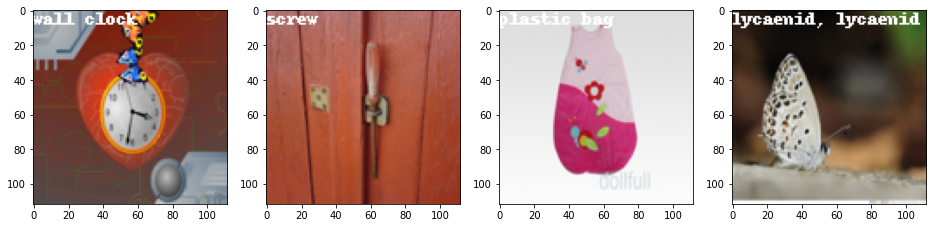

In [69]:
%matplotlib inline
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from IPython import display
import matplotlib.pyplot as plt

inline_transform = transforms.Normalize(
    mean=[0.4547857, 0.4349471, 0.40525291],
    std=[0.12003352, 0.12323549, 0.1392444]
)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

model.eval()
with torch.no_grad():
    test_dataloader = torch.utils.data.DataLoader(datasets, batch_size=1, shuffle=True, num_workers=0, pin_memory=True, drop_last=False)
    for i, (image, label) in enumerate(test_dataloader):
        if i >= 4:
            break
            
        np_image = (np.transpose(image.squeeze().numpy(), (1, 2, 0)) * 255).astype(np.uint8)
        np_label = label.numpy()
        pil_image = Image.fromarray(np_image).resize((112, 112))
        
        output = model(inline_transform(image).cuda())
        cpu_output = torch.argmax(output).cpu().numpy().squeeze()
        
        draw = ImageDraw.Draw(pil_image)
        draw.text((0, 0), list(labels.values())[cpu_output.item()], (255,255,255))
        # axs[i // 2, i % 2].imshow(np.asarray(pil_image))
        axs[i].imshow(np.asarray(pil_image))
        
plt.show()
